In [10]:
%matplotlib inline

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms

In [12]:
# LOADS CIFAR10 images which are 32 x 32 x 3 RGB images
# iter(trainloader/testloader) are iterables that come in pairs (image, label)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Choose Hyperparameters

In [13]:
num_epochs = 12 # number of epochs to train for
momentum = 0.9 # momentum for Stochastic Gradient Descent
lr = 0.001 # learning rate (eta) for gradient descent
M = 100  # number of neurons in hidden layer of neural network
p = 4  # filter window size 
N = 8

# Build Neural Network

In [14]:
import torch.nn as nn
import torch.nn.functional as F

# NO PADDING
class Net(nn.Module):
    def __init__(self, M, N, p):
        super(Net, self).__init__()
        
        # The 3 input channels are the RGB of the image
        # the Kernel size is the size of the filter window (p x p in this case)
        self.conv = nn.Conv2d(in_channels=3, out_channels=M, kernel_size=p, bias=True, padding=0)
        
        # Max pooling layer. kernel_size is the size of the window that is used. Max is selected within a N x N window
        self.pool = nn.MaxPool2d(kernel_size=N)
        
        self.linear = nn.Linear(((33-p) // N)**2 * M,  10, bias=True)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # vectorize the data before feeding it into the linear layer. Note the 4 is due to the batch of size 4 used
        # (see homework specification)
        x = x.view(4, -1)
        x = self.linear(x)
        return x
        


net = Net(M, N, p)

# 3. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

# 4. Train the network


This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [16]:
def calc_accuracy(dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return 100.0 * correct / total

In [17]:
all_train_accuracies = [calc_accuracy(trainloader)]
all_test_accuracies = [calc_accuracy(testloader)]
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    
            #train_accuracy = calc_accuracy(trainloader)
            #test_accuracy = calc_accuracy(testloader)
            #all_train_accuracies.append(train_accuracy)
            #all_test_accuracies.append(test_accuracy)
    
    train_accuracy = calc_accuracy(trainloader)
    test_accuracy = calc_accuracy(testloader)
    print('END OF EPOCH ', epoch + 1, ': train accuracy = ', train_accuracy, ' // test accuracy = ', test_accuracy)
    
        
print('Finished Training')

[1,  2000] loss: 1.842
[1,  4000] loss: 1.575
[1,  6000] loss: 1.457
[1,  8000] loss: 1.371
[1, 10000] loss: 1.337
[1, 12000] loss: 1.292
END OF EPOCH  1 : train accuracy =  55.898  // test accuracy =  54.92
[2,  2000] loss: 1.243
[2,  4000] loss: 1.248
[2,  6000] loss: 1.221
[2,  8000] loss: 1.202
[2, 10000] loss: 1.192
[2, 12000] loss: 1.166
END OF EPOCH  2 : train accuracy =  58.464  // test accuracy =  57.1
[3,  2000] loss: 1.124
[3,  4000] loss: 1.160
[3,  6000] loss: 1.142
[3,  8000] loss: 1.145
[3, 10000] loss: 1.125
[3, 12000] loss: 1.142
END OF EPOCH  3 : train accuracy =  62.892  // test accuracy =  61.17
[4,  2000] loss: 1.115
[4,  4000] loss: 1.102
[4,  6000] loss: 1.083
[4,  8000] loss: 1.098
[4, 10000] loss: 1.085
[4, 12000] loss: 1.094
END OF EPOCH  4 : train accuracy =  64.922  // test accuracy =  62.96
[5,  2000] loss: 1.070
[5,  4000] loss: 1.045
[5,  6000] loss: 1.083
[5,  8000] loss: 1.061
[5, 10000] loss: 1.063
[5, 12000] loss: 1.059
END OF EPOCH  5 : train accurac

# Plot accuracy over time






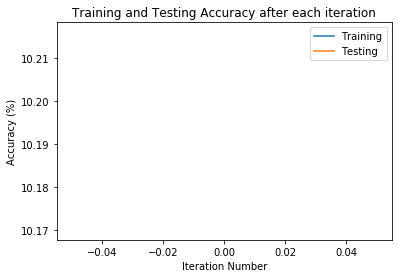

In [18]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(all_train_accuracies)
plt.plot(all_test_accuracies)
plt.title('Training and Testing Accuracy after each iteration')
plt.xlabel('Iteration Number')
plt.ylabel('Accuracy (%)')
plt.legend(['Training', 'Testing'])
plt.show()